<a href="https://colab.research.google.com/github/llluns/spotify_data_analysis/blob/main/Spotify_Data_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<h1><center> Spotify Data Exploration </center></h1>


    
<center>Name: Lauren Lunsford</center>

<center>Start Date: July 14, 2021</center>


## Read Me

Hello! Here's some stuff you should know:

This script operates off of two main datasources:
1. Personally requested spotify data: Instructions for how to retrieve this data can be found [here](https://support.spotify.com/us/article/data-rights-and-privacy-settings/) under "Can I download a copy of my personal data". If the format for the data has changed, this script may not work. 
2. The spotify web API: To access the web api you need a developer account. Instructions on how to do that are [here](https://developer.spotify.com/dashboard/login). You then need to create a file called secrets.txt that includes your client ID and client secret. 

Furthermore, if you're using this on google colab, you need to upload your spotify data to a folder in your drive and mount said drive using the code in the first cell in this file. 

There is also an accompanying tableau file and visualizatons. This will be linked.  

That's all- enjoy! 

# Early Data Analysis   <a class="anchor" id="first-bullet"></a>

## Personal Data  <a class="anchor" id="a"></a>

In [1]:
#pip install spotipy
import pandas as pd
import json
import numpy 

### Streaming History  <a class="anchor" id="b"></a>

In [4]:
#reading data directly into pandas dataframe from json
df0 = pd.read_json('drive/MyDrive/my_spotify_data/StreamingHistory0.json')
df1 = pd.read_json('drive/MyDrive/my_spotify_data/StreamingHistory1.json')
df2 = pd.read_json('drive/MyDrive/my_spotify_data/StreamingHistory2.json')

#concatenating df's into a central df
df = pd.concat([df0, df1, df2])

#making sure there's no data loss
print(len(df0),len(df1), len(df2), len(df))
df.head()

10000 10000 5042 25042


,endTime,artistName,trackName,msPlayed
0,2020-07-11 00:19,Russian Cursive,Backwards,179813
1,2020-07-11 00:32,Russian Cursive,Backwards,179813
2,2020-07-11 03:37,Russian Cursive,Backwards,113963
3,2020-07-11 06:40,Toro y Moi,Mirage,114282
4,2020-07-11 06:42,Aru-2,Dwell,137142


##### Favorite Artists

In [6]:
df_a=df.copy()
df_a=df_a.groupby(['artistName']).sum() #summing by that unique id (so get total listen time on each song)
df_a=df_a.sort_values(by=['msPlayed'],ascending=False)
df_a.head()

,msPlayed
artistName,
No Dumb Questions,71698724
Hiatus Kaiyote,27856499
KOKOROKO,26283440
Vulfpeck,23391811
Justice Der,21751707


##### Favorite Songs

In [7]:
#looking at total time Played 
df_time=df.copy()
df_time['id']=df_time['artistName'] + ", " + df_time['trackName'] #creating unique identifier 
df_time=df_time.groupby(['id']).sum() #summing by that unique id (so get total listen time on each song)
df_time=df_time.sort_values(by=['msPlayed'],ascending=False)
df_time['minsPlayed']=df_time['msPlayed']/1000/60
df_time['hrsPlayed']=df_time['minsPlayed']/60
df_time.head(5)

,msPlayed,minsPlayed,hrsPlayed
id,,,
"Lawrence, Freckles",20245668,337.427800,5.623797
"KOKOROKO, Abusey Junction",17377514,289.625233,4.827087
"Vulfpeck, Baby I Don’t Know Oh Oh (feat. Charles Jones)",14449878,240.831300,4.013855
"New Order, Age of Consent - 2015 Remaster",12862872,214.381200,3.573020
"The Happy Fits, Too Late",12021252,200.354200,3.339237


 #### <font color='red'>Add data visualization here</font>  


### Playlist Data <a class="anchor" id="c"></a>

In [59]:
with open('drive/MyDrive/my_spotify_data/Playlist1.json') as f:
    playlist_data = json.load(f)
playlists=playlist_data['playlists']
playlist_network=[]
PLS={}
df_PL={}

for playlist in playlists: 
    PL=[]
    name=playlist['name']
    items=playlist['items'] #Grabbing all songs in the playlist
    for item in items: #for each song
        try:
            song=item['track']['trackName']+", "+item['track']['albumName'] #grab the song and album to make an ID
            if song in df_PL:
              df_PL[song][4]+=1
              df_PL[song][5].append(name)
            else:
              uri_=item['track']['trackUri'] #grabbing uri statement
              uri=uri_.split(':')[2] #split it by : since there's unnecessary text and just grab the uri
              df_PL[song]= [item['track']['trackName'], item['track']['albumName'],  item['track']['artistName'], uri,  1 , [name]]
        except:
            song="ERROR" # if there's a nonetype, just make it error idk i'll fix it if there's a lot of them
        PL.append(song) #add the song id to a list called PL
        #now gathering data for node specific stuff for the URI and stuff
        
    PLS[name]=PL #add each playllist (PL) to a list of playlists
order=['song','album','artist','uri','instances']

In [116]:
df_pl=pd.DataFrame.from_dict(df_PL, orient='index') 
df_pl=df_pl.rename(columns= {0:'song', 1:'album',2:'artist', 3:'uri',4:'instances',5:'playlists'})
df_pl.head()


,song,album,artist,uri,instances,playlists
"Navajo, Navajo",Navajo,Navajo,Masego,6zWU7YALeEDMcPGhKKZJhV,4,"[Iykyk, These have no common theme other than ..."
"Wasn't Looking, A Real Romantic",Wasn't Looking,A Real Romantic,ELIZA,7kw7eF5H8qLQU0IxbT2gq6,3,"[Iykyk, These have no common theme other than ..."
"Tadow, Lady Lady",Tadow,Lady Lady,Masego,51rPRW8NjxZoWPPjnRGzHw,6,"[Iykyk, These have no common theme other than ..."
"Cola, Cola",Cola,Cola,Arlo Parks,0i6c86ntKJoZpKk8aCHL3c,7,"[Iykyk, fuck, man, ok ok ok , These have no co..."
"Crossfire / So Into You, Needle Paw",Crossfire / So Into You,Needle Paw,Nai Palm,2VsKJODsXzU1NtoFYIh9FM,2,"[Iykyk, White Washed + a Sax (Sex)]"


In [61]:
#getting URIS to retrieve data
uris=list(df_pl['uri'])

## Networks perspective

In [14]:
## Creating data for network view x
##This takes a while- need to find how to make it take less time
edges=[]
for PL in PLS.keys(): #for each playlist in that list of playlists
    for song in PLS[PL]:  #grab one song
        for song1 in PLS[PL]: #then grab another song from that same list
            if song != song1:  #make sure those songs aren't the same 
                if (song, song1, {'playlist': PL}) not in edges:  #then add song 1 and song 2 to the edges, if theyre not already there
                    edges.append((song, song1,{'playlist': PL}))

In [15]:
edges[0]

('Navajo, Navajo', "Wasn't Looking, A Real Romantic", {'playlist': 'Iykyk'})

It looks like no two songs are in two or more playlists together, therefore, I am going to disregard weight

### Song Network

In [16]:
#creating network
import networkx as nx
G = nx.Graph()
G.add_edges_from(edges)

#making sure there's edge data
G.get_edge_data('Navajo, Navajo', 'If You Want Me to Stay, Fresh') 


{'playlist': 'These have no common theme other than being the best'}

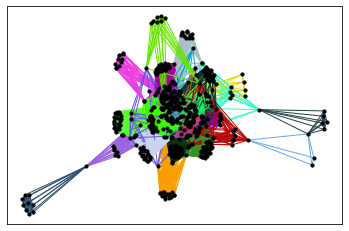

In [20]:
#drawing network
import random
playlist_names=list(PLS.keys())
color_map={}
for i in range(len(playlist_names)):
    color = "%06x" % random.randint(0, 0xFFFFFF)
    color_map[playlist_names[i]]="#"+color 
n_colors = [color_map[G.get_edge_data(u,v)["playlist"]] for u, v in list(G.edges())]
drawing=nx.draw_networkx(G,node_color = 'k', edge_color = n_colors, with_labels=False, node_size=10)

In [ ]:
print(nx.info(G))
print('1. # Nodes: ',  len(G.nodes()))
print('2. # Edges: ',  len(G.edges()))
print('4. average shortest path', nx.average_shortest_path_length(G) )
print('5. average degree: ', float(nx.info(G).split('\n')[-1][17:]))
print('6. average clustering coefficient: ', nx.average_clustering(G) )

1. # Nodes:  539
2. # Edges:  20953
4. average shortest path 2.134635942920595
5. average degree:  77.7477
6. average clustering coefficient:  0.886831885883536


betweeness 

### Artist Network 

# Spotify API requests


In [34]:
import requests
import json
import urllib
import time
import numpy as np
import pandas as pd
import pickle
import multiprocessing
from concurrent.futures import ThreadPoolExecutor


In [36]:
CLIENT_ID = open("drive/MyDrive/my_spotify_data/secrets.txt").read().splitlines()[0]
CLIENT_SECRET = open("drive/MyDrive/my_spotify_data/secrets.txt").read().splitlines()[1]

In [37]:
def authenticate(client_id,client_secret):

	AUTH_URL = 'https://accounts.spotify.com/api/token'
	
	#POST
	auth_response = requests.post(AUTH_URL,{
		'grant_type': 'client_credentials',
		'client_id': client_id,
		'client_secret': client_secret})

	# save the access token
	access_token = auth_response.json()['access_token']
	return access_token


In [166]:
def getsong_details(uri,headers):
	url = "https://api.spotify.com/v1/audio-features/{item}".format(item = uri)
	results = {}
	try:
		r = requests.get(url, headers = headers).text
		#print(r)
		j = json.loads(r)
		# results.append((
		# 	j['danceability'],j['energy'],j['key'],j['mode'],j['acousticness'],j['instrumentalness'],
		# 	j['tempo'],j["valence"],j["speechiness"],j["loudness"]))
		results["danceability"] = j['danceability']
		results["energy"] = j['energy']
		results["key"] = j['key']
		results["mode"] = j['mode']
		results["acousticness"] = j['acousticness']
		results["instrumentalness"] = j['instrumentalness']
		results["tempo"] = j['tempo']
		results["valence"] = j['valence']
		results["speechiness"] = j['speechiness']
		results["loudness"] = j['loudness']

	except:
		return "error"

	return results

In [167]:
access_token=authenticate(CLIENT_ID,CLIENT_SECRET)
headers = {'Authorization': 'Bearer {token}'.format(token=access_token)}

#results test
getsong_details(uris[0], headers)

{'acousticness': 0.117,
 'danceability': 0.567,
 'energy': 0.593,
 'instrumentalness': 1.32e-06,
 'key': 6,
 'loudness': -7.404,
 'mode': 0,
 'speechiness': 0.288,
 'tempo': 88.545,
 'valence': 0.358}

### Adding Spotify API Data to DF

In [153]:
def populate_details(row):
  uri=row['uri']
  uri=uri.to_string().split("    ")[1]
  d=getsong_details(uri, headers)
  row['acousticness']=d['acousticness']
  row['danceability']=d['danceability']
  row['energy']=d['energy']
  row['key']=d['key']
  row['loudness']=d['loudness']
  row['mode']=d['mode']
  row['speechiness']=d['speechiness']
  row['tempo']=d['tempo']
  row['valence']=d['valence']


In [158]:
def populate_details(uri):
  d=getsong_details(uri, headers)
  acousticness=d['acousticness']
  danceability=d['danceability']
  energy=d['energy']
  key=d['key']
  loudness=d['loudness']
  mode=d['mode']
  speechiness=d['speechiness']
  tempo=d['tempo']
  valence=d['valence']
  return [acousticness, danceability, energy, key, loudness, mode, speechiness, tempo, valence]


In [176]:
populate_details(uri)

[0.117, 0.567, 0.593, 6, -7.404, 0, 0.288, 88.545, 0.358]

Gathering Data 100 at a Time

In [187]:
song_data={}
for uri in uris[0:100]:
  song_data[uri] =populate_details(uri)

In [189]:
for uri in uris[100:200]:
  song_data[uri] =populate_details(uri)

In [191]:
for uri in uris[200:300]:
  song_data[uri] =populate_details(uri)

In [ ]:
for uri in uris[300:400]:
  song_data[uri] =populate_details(uri)

In [196]:
for uri in uris[400:500]:
  song_data[uri] =populate_details(uri)

In [218]:
for uri in uris[500:538]:
  song_data[uri] =populate_details(uri)
df_song_data=pd.DataFrame.from_dict(song_data, orient='index')  

In [219]:
df_song_data=df_song_data.rename(columns={0:'acousticness',1:'danceability',2:'energy',3:'key',
                             4:'loudness', 5:'mode', 6:'speechiness', 7:'tempo',8:'valence' }) 
df_song_data.head()

,acousticness,danceability,energy,key,loudness,mode,speechiness,tempo,valence
6zWU7YALeEDMcPGhKKZJhV,0.1170,0.567,0.593,6,-7.404,0,0.2880,88.545,0.358
7kw7eF5H8qLQU0IxbT2gq6,0.0858,0.845,0.176,5,-9.973,0,0.0598,82.004,0.587
51rPRW8NjxZoWPPjnRGzHw,0.6690,0.704,0.487,9,-6.407,0,0.0604,121.726,0.313
0i6c86ntKJoZpKk8aCHL3c,0.1980,0.814,0.742,4,-10.520,0,0.2400,75.451,0.587
2VsKJODsXzU1NtoFYIh9FM,0.9250,0.484,0.367,9,-8.459,1,0.0374,81.038,0.377


# Data Unification   <a class="anchor" id="second-bullet"></a>

In [ ]:
### ONLY RUN THIS CELL ONCE OTHERWISE IT'LL KEEP ADDING COLUMNS OF INDEXES
df_song_data.reset_index(level=0, inplace=True)

In [222]:
df_song_data=df_song_data.rename(columns={'index':'uri'} )
df_song_data.head()

,uri,acousticness,danceability,energy,key,loudness,mode,speechiness,tempo,valence
0,6zWU7YALeEDMcPGhKKZJhV,0.1170,0.567,0.593,6,-7.404,0,0.2880,88.545,0.358
1,7kw7eF5H8qLQU0IxbT2gq6,0.0858,0.845,0.176,5,-9.973,0,0.0598,82.004,0.587
2,51rPRW8NjxZoWPPjnRGzHw,0.6690,0.704,0.487,9,-6.407,0,0.0604,121.726,0.313
3,0i6c86ntKJoZpKk8aCHL3c,0.1980,0.814,0.742,4,-10.520,0,0.2400,75.451,0.587
4,2VsKJODsXzU1NtoFYIh9FM,0.9250,0.484,0.367,9,-8.459,1,0.0374,81.038,0.377


In [206]:
df_pl.head()

,song,album,artist,uri,instances,playlists
"Navajo, Navajo",Navajo,Navajo,Masego,6zWU7YALeEDMcPGhKKZJhV,4,"[Iykyk, These have no common theme other than ..."
"Wasn't Looking, A Real Romantic",Wasn't Looking,A Real Romantic,ELIZA,7kw7eF5H8qLQU0IxbT2gq6,3,"[Iykyk, These have no common theme other than ..."
"Tadow, Lady Lady",Tadow,Lady Lady,Masego,51rPRW8NjxZoWPPjnRGzHw,6,"[Iykyk, These have no common theme other than ..."
"Cola, Cola",Cola,Cola,Arlo Parks,0i6c86ntKJoZpKk8aCHL3c,7,"[Iykyk, fuck, man, ok ok ok , These have no co..."
"Crossfire / So Into You, Needle Paw",Crossfire / So Into You,Needle Paw,Nai Palm,2VsKJODsXzU1NtoFYIh9FM,2,"[Iykyk, White Washed + a Sax (Sex)]"


In [225]:
result = pd.merge(df_pl,df_song_data, on="uri")
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 538 entries, 0 to 537
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   song          538 non-null    object 
 1   album         538 non-null    object 
 2   artist        538 non-null    object 
 3   uri           538 non-null    object 
 4   instances     538 non-null    int64  
 5   playlists     538 non-null    object 
 6   acousticness  538 non-null    float64
 7   danceability  538 non-null    float64
 8   energy        538 non-null    float64
 9   key           538 non-null    int64  
 10  loudness      538 non-null    float64
 11  mode          538 non-null    int64  
 12  speechiness   538 non-null    float64
 13  tempo         538 non-null    float64
 14  valence       538 non-null    float64
dtypes: float64(7), int64(3), object(5)
memory usage: 67.2+ KB


Ideal data structure:
Nodes List: 
Index. Spotify ID. Song. Feature 1. Feature 2. Feature 3  

^^Add each feature into the node feature to visualize results based on features.

# Export Data to Tableau / PowerBI for Visualizations

In [ ]:
#all listening data
df.to_csv('all_listening_data.csv')

#songs network data
edges.to_csv('song_network.csv')

#artists network data
df.to_csv('artist_network.csv')

#all playlist data
result.to_csv('plalist_data.csv')



In [ ]:
from google.colab import files
files.download("all_listening_data.csv",'song_network.csv','artist_network.csv','plalist_data.csv')

# Code Graveyard

In [ ]:
##### kinda obsolete because of inclusion of playlist in tuple
#TRYING TO GET WEIGHTS (IF THE SAME TWO SONGS ARE IN MORE THAN ONE PLAYLIST)
edges[0]
e= pd.DataFrame(edges) #making it a df so i can get the weights of the edges
e['edge']= e[0] + "--" +e[1] #creating an ID to groupby
e['weight']=1 # adding a weight initial of 1 per edge
e=e.drop(columns=[0,1]) #dropping other columns so it's easier to deal with
sort=e.groupby('edge').sum() #grouping by edge, and summing the weight. Any repeat instances will have a 
#weight that is the sum of the instances
sort=sort.sort_values(by='weight',ascending=False) #sorting it so you can see the highest weight
sort.head(3)

In [ ]:
index = df_pl.index
num_of_rows = len(index)
for i in range(num_of_rows):
  if i==0:
    pass
  else: 
    a=i-1
    df_pl[a:i].apply(lambda x: populate_details(x))
  

